In [1251]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np               
import matplotlib.pyplot as plt  
import scipy                     
from IPython import display

              

pykat.init_pykat_plotting(dpi=200)

kat=finesse.kat()
kat_PRM=finesse.kat()
kat.verbose=1
kat_PRM.verbose=1

<h2>BASECODE</h2>

<p>Input Laser ---> BS for PRM angular sensing ---> PRM ---> BS for ITM/ETM sensing ---> ITM ---> ETM</p>

In [1252]:
kat.parse("""

maxtem 3
l laser 30 0 n1                          #laser 1W
s gap01 1 n1 n2                         #space b/w mod and laser  
mod sb1 55.5556M 0.001 3 pm n2 n3         #modulator PM 55.5556M 3f
s gap02 0.5 n3 n31                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31 dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12

attr s2 g 45                                 #guoy phase for det1
attr sQPD1 g 160                                 #guoy phase for det1
attr sQPD2 g 250                                #guoy phase for det2

pd1 QPDrefl1 166.6668M 0 a11                       #Split detector1 refl
pdtype QPDrefl1 x-split   
pd1 QPDrefl2 166.6668M 90 a12                       #Split detector2 refl
pdtype QPDrefl2 x-split  


### scale all QPDs outputs ###
set QPDrefl1n QPDrefl1 re
func QPDrefl1_PRM = $QPDrefl1n*10000000
set QPDrefl2n QPDrefl2 re
func QPDrefl2_PRM = $QPDrefl2n*10000000
###############################

#######################


##### FOR ANGULAR SENSING ITM/ETM #####
s sr 0.01 n12 n12a    
bs pickoff1 0.0001 0.9999 0 45 n12a dump n121 refl_itm
s s21 0.1 refl_itm a81                       
bs bsQPD1 0.5 0.5 0 45 a81 a91 a101 dump            #bs to split power between two detectors 

s sQPD11 0.1 a91 a11a                   
s sQPD21 0.1 a101 a12a

attr s21 g 10                                 #guoy phase for det1
attr sQPD11 g 90                                 #guoy phase for det1
attr sQPD21 g 180                                #guoy phase for det2

pd1 QPDrefl1_itm 55.5556M 0 a11a                       #Split detector1 refl
pdtype QPDrefl1_itm x-split   
pd1 QPDrefl2_itm 55.5556M 90 a12a                       #Split detector2 refl
pdtype QPDrefl2_itm x-split  

#########################



####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.759 0.1 90 refl pop               #PRM                ---> POP <---
#m PRM 0 1 90 refl pop               #PRM
s PRC 1.350 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.29 n121 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 90 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################
cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3

trace 2 


##### attr for TM ######

attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM

attr PRM xbeta 0            # misalgnment 
attr ETM xbeta 0         
attr ITM xbeta 0 
######################


##### PD #######

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6
 

pd1 refl_I 55.5556M 0 refl_a              # REFL I  1f
pd1 refl_Q 55.5556M 90 refl_a             # REFL Q  1f
pd1 refl_I_f3 166.6668M 0 refl_a          # REFL I  3f
pd1 refl_Q_f3 166.6668M 90 refl_a         # REFL Q  3f
pd1 pop_I_raw 55.5556M 0 pop                # POP I  1f
pd1 pop_Q_raw 55.5556M 90 pop               # POP Q  1f
pd1 pop_I_f3_raw 166.6668M 0 pop            # POP I  3f
pd1 pop_Q_f3_raw 166.6668M 90 pop           # POP Q  3f

################






#x2axis ITM xbeta lin -0.3m 0.3m 800            #for 3d graph plotting

#xaxis PRM xbeta lin 0 0.3m 200
#xaxis ETM phi lin 85 95 900
#func prm_tune = 90 + $x1*0.1
#put PRM phi $prm_tune
yaxis lin abs

 

""")

Parsing `set QPDrefl1n QPDrefl1 re` into pykat object not implemented yet, added as extra line.
Parsing `set QPDrefl2n QPDrefl2 re` into pykat object not implemented yet, added as extra line.


<h2>  ETM Angular Sensing</h2>

In [1253]:
kat_ETM = kat.deepcopy()
kat_ETM.parse("""


#### LOCK ETM ####
set errs pop_I_f3_raw re
lock clocks $errs -3000 10n
put* ETM phi $clocks
noplot clocks
#####


xaxis ETM xbeta lin 0 5u 500

""")

out1 = kat_ETM.run()
out1.info()
#out.plot()

Parsing `set errs pop_I_f3_raw re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-10-19 11:59:44.791433


 93% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 0/10000)    

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 1.71645 seconds

--- Output info ---

Run date and time: 2022-10-19 11:59:44.792424
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, circ_arm, circ_prc, clocks, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis ETM xbeta lin 0 5e-06 500']
QPDrefl1     : min = -1.000794953480510e-16 max = 0.000000000000000e+00
QPDrefl2     : min = -4.841641003645090e-18 max = 6.732710957129790e-17
QPDrefl1_itm : min = 0.000000000000000e+00 max = 2.214067256541250e-07
QPDrefl2_itm : min = -1.354112440608020e-07 max = 0.000000000000000e+00
circ_arm     : min = 2.863634003406100e+03 max = 3.717159412176390e+04
circ_prc     : min = 8.381029219761370e+00 max = 9.851644582493290e+01
refl         : min = 3.252108388598790e+00 max = 2.392126433283000e+01
trans        : min = 2.863748553352950e-02 max = 3.7173081045

100% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 0/10000)    

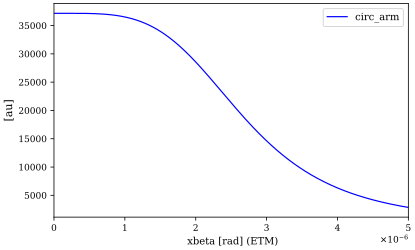

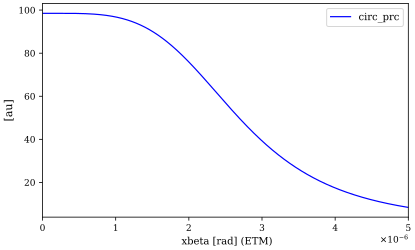

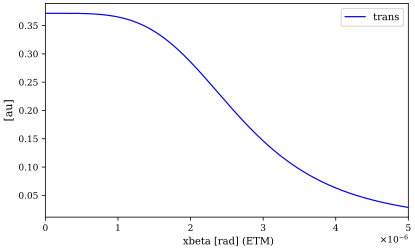

In [1254]:
out1.plot(['circ_arm'])
out1.plot(['circ_prc'])
out1.plot(['trans'])

In [1255]:
#out1.plot(['refl_Q','refl_I'])
#out1.plot(['refl_I_f3','refl_Q_f3'])
#
#out1.plot(['pop_I_raw','pop_Q_raw'])
#out1.plot(['pop_I_f3_raw','pop_Q_f3_raw'])

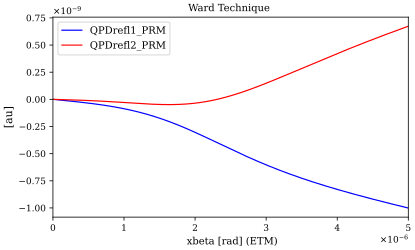

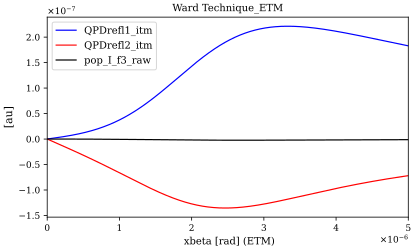

In [1256]:
### ETM is sensed using QPDrefl1_itm and QPDrefl2_itm (second graph)###
### Guoy phase tuned such that the signals have opposite slope ###  

out1.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out1.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ETM')

In [1257]:
#i=0
#for i in np.arange(0,360, 10):
#    kat_ETM.sQPD11.gouy = i
#    kat_ETM.sQPD21.gouy = i+90
#    #i = i+40
#    out3 = kat_ETM.run()
#    #out3.info()
#    print(i)
#    out3.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ITM')
#    #out1.plot(['QPDrefl1','QPDrefl2'],title='Ward Technique ')

<h2>  ITM Angular Sensing</h2>

In [1258]:
kat_ITM = kat.deepcopy()
kat_ITM.parse("""


#### LOCK ETM ####
set errs pop_I_f3_raw re
lock clocks $errs -3000 10n
put* ETM phi $clocks
noplot clocks
#####


xaxis ITM xbeta lin 0 5u 500

""")

out2 = kat_ITM.run()
out2.info()
#out.plot()

Parsing `set errs pop_I_f3_raw re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-10-19 11:59:48.520254


 89% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 0/10000)    

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 1.75595 seconds

--- Output info ---

Run date and time: 2022-10-19 11:59:48.521256
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, circ_arm, circ_prc, clocks, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis ITM xbeta lin 0 5e-06 500']
QPDrefl1     : min = -1.691451476542780e-15 max = 0.000000000000000e+00
QPDrefl2     : min = 0.000000000000000e+00 max = 3.932675271858070e-15
QPDrefl1_itm : min = -5.731565805134230e-07 max = 9.624916739646859e-09
QPDrefl2_itm : min = 0.000000000000000e+00 max = 7.274460779865170e-07
circ_arm     : min = 5.361833576772590e+03 max = 3.717160621358340e+04
circ_prc     : min = 1.495800832910860e+01 max = 9.851661170148340e+01
refl         : min = 3.252082263678000e+00 max = 2.241428782808290e+01
trans        : min = 5.362048058694940e-02 max = 3.71730931373

100% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 0/10000)    

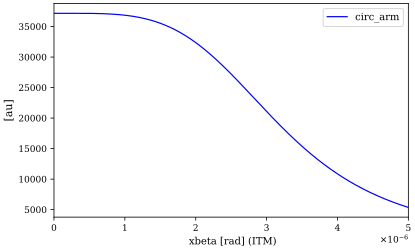

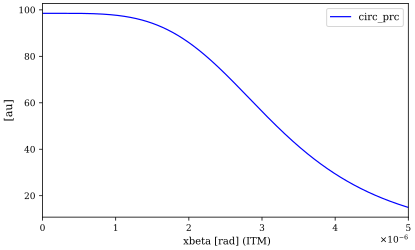

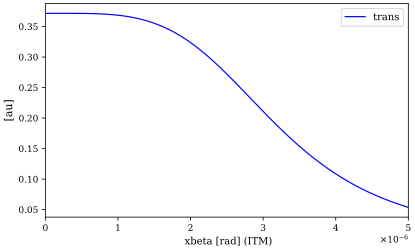

In [1259]:
out2.plot(['circ_arm'])
out2.plot(['circ_prc'])
out2.plot(['trans'])

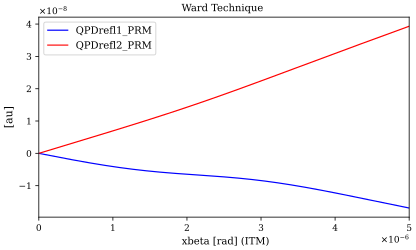

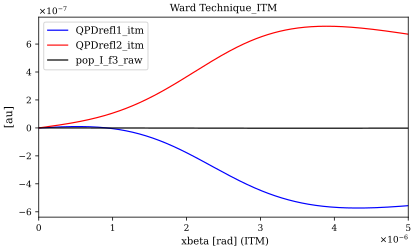

In [1260]:
### ITM is sensed using QPDrefl1_itm and QPDrefl2_itm (second graph) effect can also be seen in first graph (PRM sensing)###
### Guoy phase tuned such that the one signal is zero###  

out2.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out2.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ITM')

<h2>  PRM Angular Sensing</h2>

In [1261]:
kat_PRM = kat.deepcopy()
kat_PRM.parse("""


#### LOCK PRM ####
set errs refl_I re
func errsn = $errs*50
lock clocks $errsn -3000 1n
put* PRM phi $clocks
noplot clocks
#####


xaxis PRM xbeta lin 0u 50u 500

""")

out3 = kat_PRM.run()
out3.info()
#out.plot()

Parsing `set errs refl_I re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-10-19 11:59:51.806547


100% | ETA:  0:00:00 | Calculating - Locked X (Locking steps tried 132/10000)  

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 126.261 seconds

--- Output info ---

Run date and time: 2022-10-19 11:59:51.806547
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, circ_arm, circ_prc, clocks, errsn, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis PRM xbeta lin 0 5e-05 500']
QPDrefl1     : min = 0.000000000000000e+00 max = 1.300152684921880e-14
QPDrefl2     : min = -5.986830623912200e-15 max = 1.892751601932780e-16
QPDrefl1_itm : min = -1.146986252923140e-06 max = 0.000000000000000e+00
QPDrefl2_itm : min = -3.819047230555800e-07 max = 6.915556319190990e-07
circ_arm     : min = 5.903329003337310e+03 max = 3.716722949376230e+04
circ_prc     : min = 1.633980611282110e+01 max = 9.850495444818060e+01
refl         : min = 3.254741282671950e+00 max = 2.209093752183150e+01
trans        : min = 5.903565145943140e-02 max = 3.716

100% | ETA:  0:00:00 | Calculating - Locked X (Locking steps tried 73/10000)   

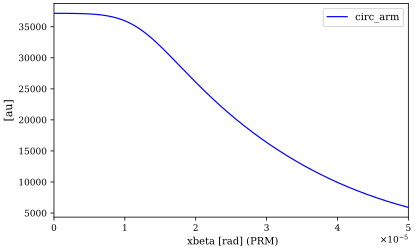

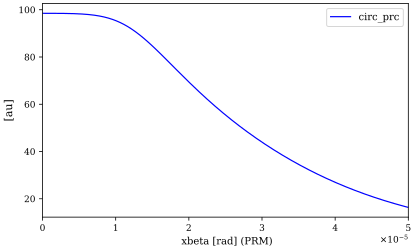

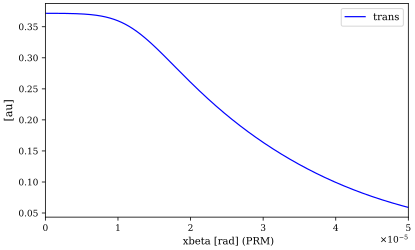

In [1262]:
out3.plot(['circ_arm'])
out3.plot(['circ_prc'])
out3.plot(['trans'])

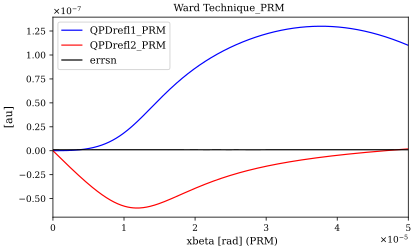

In [1263]:
### PRM is sensed using QPDrefl1_PRM and QPDrefl1_PRM###
### Guoy phase tuned such that the one signal is zero###  

out3.plot(['QPDrefl1_PRM','QPDrefl2_PRM','errsn'],title='Ward Technique_PRM ')
#out3.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ITM')

In [1264]:
#out3.plot(['refl_Q','refl_I'])
#out3.plot(['errsn'])
#out3.plot(['refl_I_f3','refl_Q_f3'])
#
#out3.plot(['pop_I_raw','pop_Q_raw'])
#out3.plot(['pop_I_f3_raw','pop_Q_f3_raw'])

In [1265]:
#i=0
#for i in np.arange(0, 360,20):
#    kat_PRM.refl_I.phase1 = i
#    kat_PRM.sQPD1.gouy = i
#    kat_PRM.sQPD2.gouy = i+90
#    out3 = kat_PRM.run()
#    out3.info()
#    out3.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique_PRM')
#    print(i)